# Travel Insurance Modelling

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import loguniform, randint
import plotly.express as px
from sklearn.model_selection import cross_validate
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
import functions as fn
import matplotlib.pyplot as plt

This Jupyter Notebook contains analysis on customerst that have purchased a Tour & Travels Company's Travel Insurance from 2019 alongside explanatory variables of each customer. The purpose of this analysis is to attempt to create the most accurate (more on that later) model for prediction of which customers will be inclined to purchase travel insurance and which - not. The flip side of this is that this analysis will try to mimic the proper machine learning process start to finish. Therefore the goals of this analysis are two-fold:

1. Create the most accurate model for predicting potential customers based on the data we have.
2. Do so via proper machine learning process (both for educational & examplary reasons).

# Table of Contents

1. EDA & Data Prep
2. Model Development

    3.1 Model Setup

    3.2 Cross Validation

    3.3 Hyperparameter Tuning

    3.4 Trying Out PCA
3. Final Testing Of Best Models
4. Conclusions
5. Improvements to make

But first, let's download the data!

In [2]:
data = pd.read_csv('TravelInsurancePrediction.csv', index_col= 'Unnamed: 0')
data.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [3]:
data.isnull().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Sweet! It seems as thought we have no null values in any of the columns, letting us side-step any potential imputation or other Null-value handling solutions we would have had to use. Before we go any further, let's split the dataset into three separate datsets - the training, validation & testing sets. 80% of the entire dataset will be devoted to training & the rest 20% wil be divided to validation & training datasets equally.

In [4]:
target_variable = data['TravelInsurance']
target_variable_column = 'TravelInsurance'
chronic_diseases_categorical_variable = data['ChronicDiseases']

In [5]:
train_data, test_validation_data = train_test_split(data, test_size=0.2, random_state=12,
                                                    stratify=data[target_variable_column])

validation_data, test_data = train_test_split(test_validation_data,
                                              test_size=0.5,
                                              random_state=12,
                                              stratify = test_validation_data[target_variable_column])

`Training data` we will use only for model training purposes (a.k.a. building the model and using the data to define parameters of each model we use).

`Validation data` will be used as our first line of defence against overfitting - in a sense, after building a model, this will be the dataset we test ur model against. 

`Testing data`, on the other hand, will only be used once for each model in this analysis - to perform the final accuracy testing of the models we build.

In [6]:
print(f"Train dataset count: {train_data.shape[0]}")
print(f"Validation dataset row count: {validation_data.shape[0]}")
print(f"Testing dataset row count: {test_data.shape[0]}")

Train dataset count: 1589
Validation dataset row count: 199
Testing dataset row count: 199


As we can see we have 1589 rows in the Training data & 199 rows in both the training and validation datasets. Seems like good enough for me! 

From here on out, the entirity of the analysis will be performed on the training data and validation & testing data will only be used precisely for that - validation & testing. Let's also define what the categorical and numeric variables we have in the dataset.

In [7]:
explanatory_variables = data.drop(columns=['TravelInsurance'])

categorical_variables = ['Employment Type',
                         'GraduateOrNot',
                         'ChronicDiseases',
                         'FrequentFlyer',
                         'EverTravelledAbroad']
numeric_variables = ['Age', 'AnnualIncome']

We have 5 categorical variables & 2 numeric ones. Let's see what they mean:

`Age`- Age Of The Customer

`Employment Type` - The Sector In Which Customer Is Employed

`GraduateOrNot`- Whether The Customer Is College Graduate Or Not

`AnnualIncome`- The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]

`FamilyMembers`- Number Of Members In Customer's Family

`ChronicDisease`- Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.

`FrequentFlyer`- Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].

Some of these already are numeric let's look at their descriptive statistics:

In [8]:
train_data.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1589.000000,1.589000e+03,1589.000000,1589.000000,1589.000000
mean,29.706734,9.353682e+05,4.764632,0.283197,0.357458
std,2.920368,3.773643e+05,1.612290,0.450693,0.479402
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


It seems as though the majority of the company's customers are from the age of 28-32. The average age would be around 29.7 years of age. The annual income seems to be fluctuating quite a lot, which is good - this means that we don't only have a one-sided dataset. The average Annual Income is around 935368 Rupees, but it can also jup as high as 1.8 million Rupees. The same amount of variety can be seen in the `FamilyMembers` column. Around 30% of customers have Chronic Illnesses and round 35% of all clients purchase Travel Insurance. It's quite a sizable amount so that's pretty good. Let's look t some of the interplay between these numeric and categorical variables.

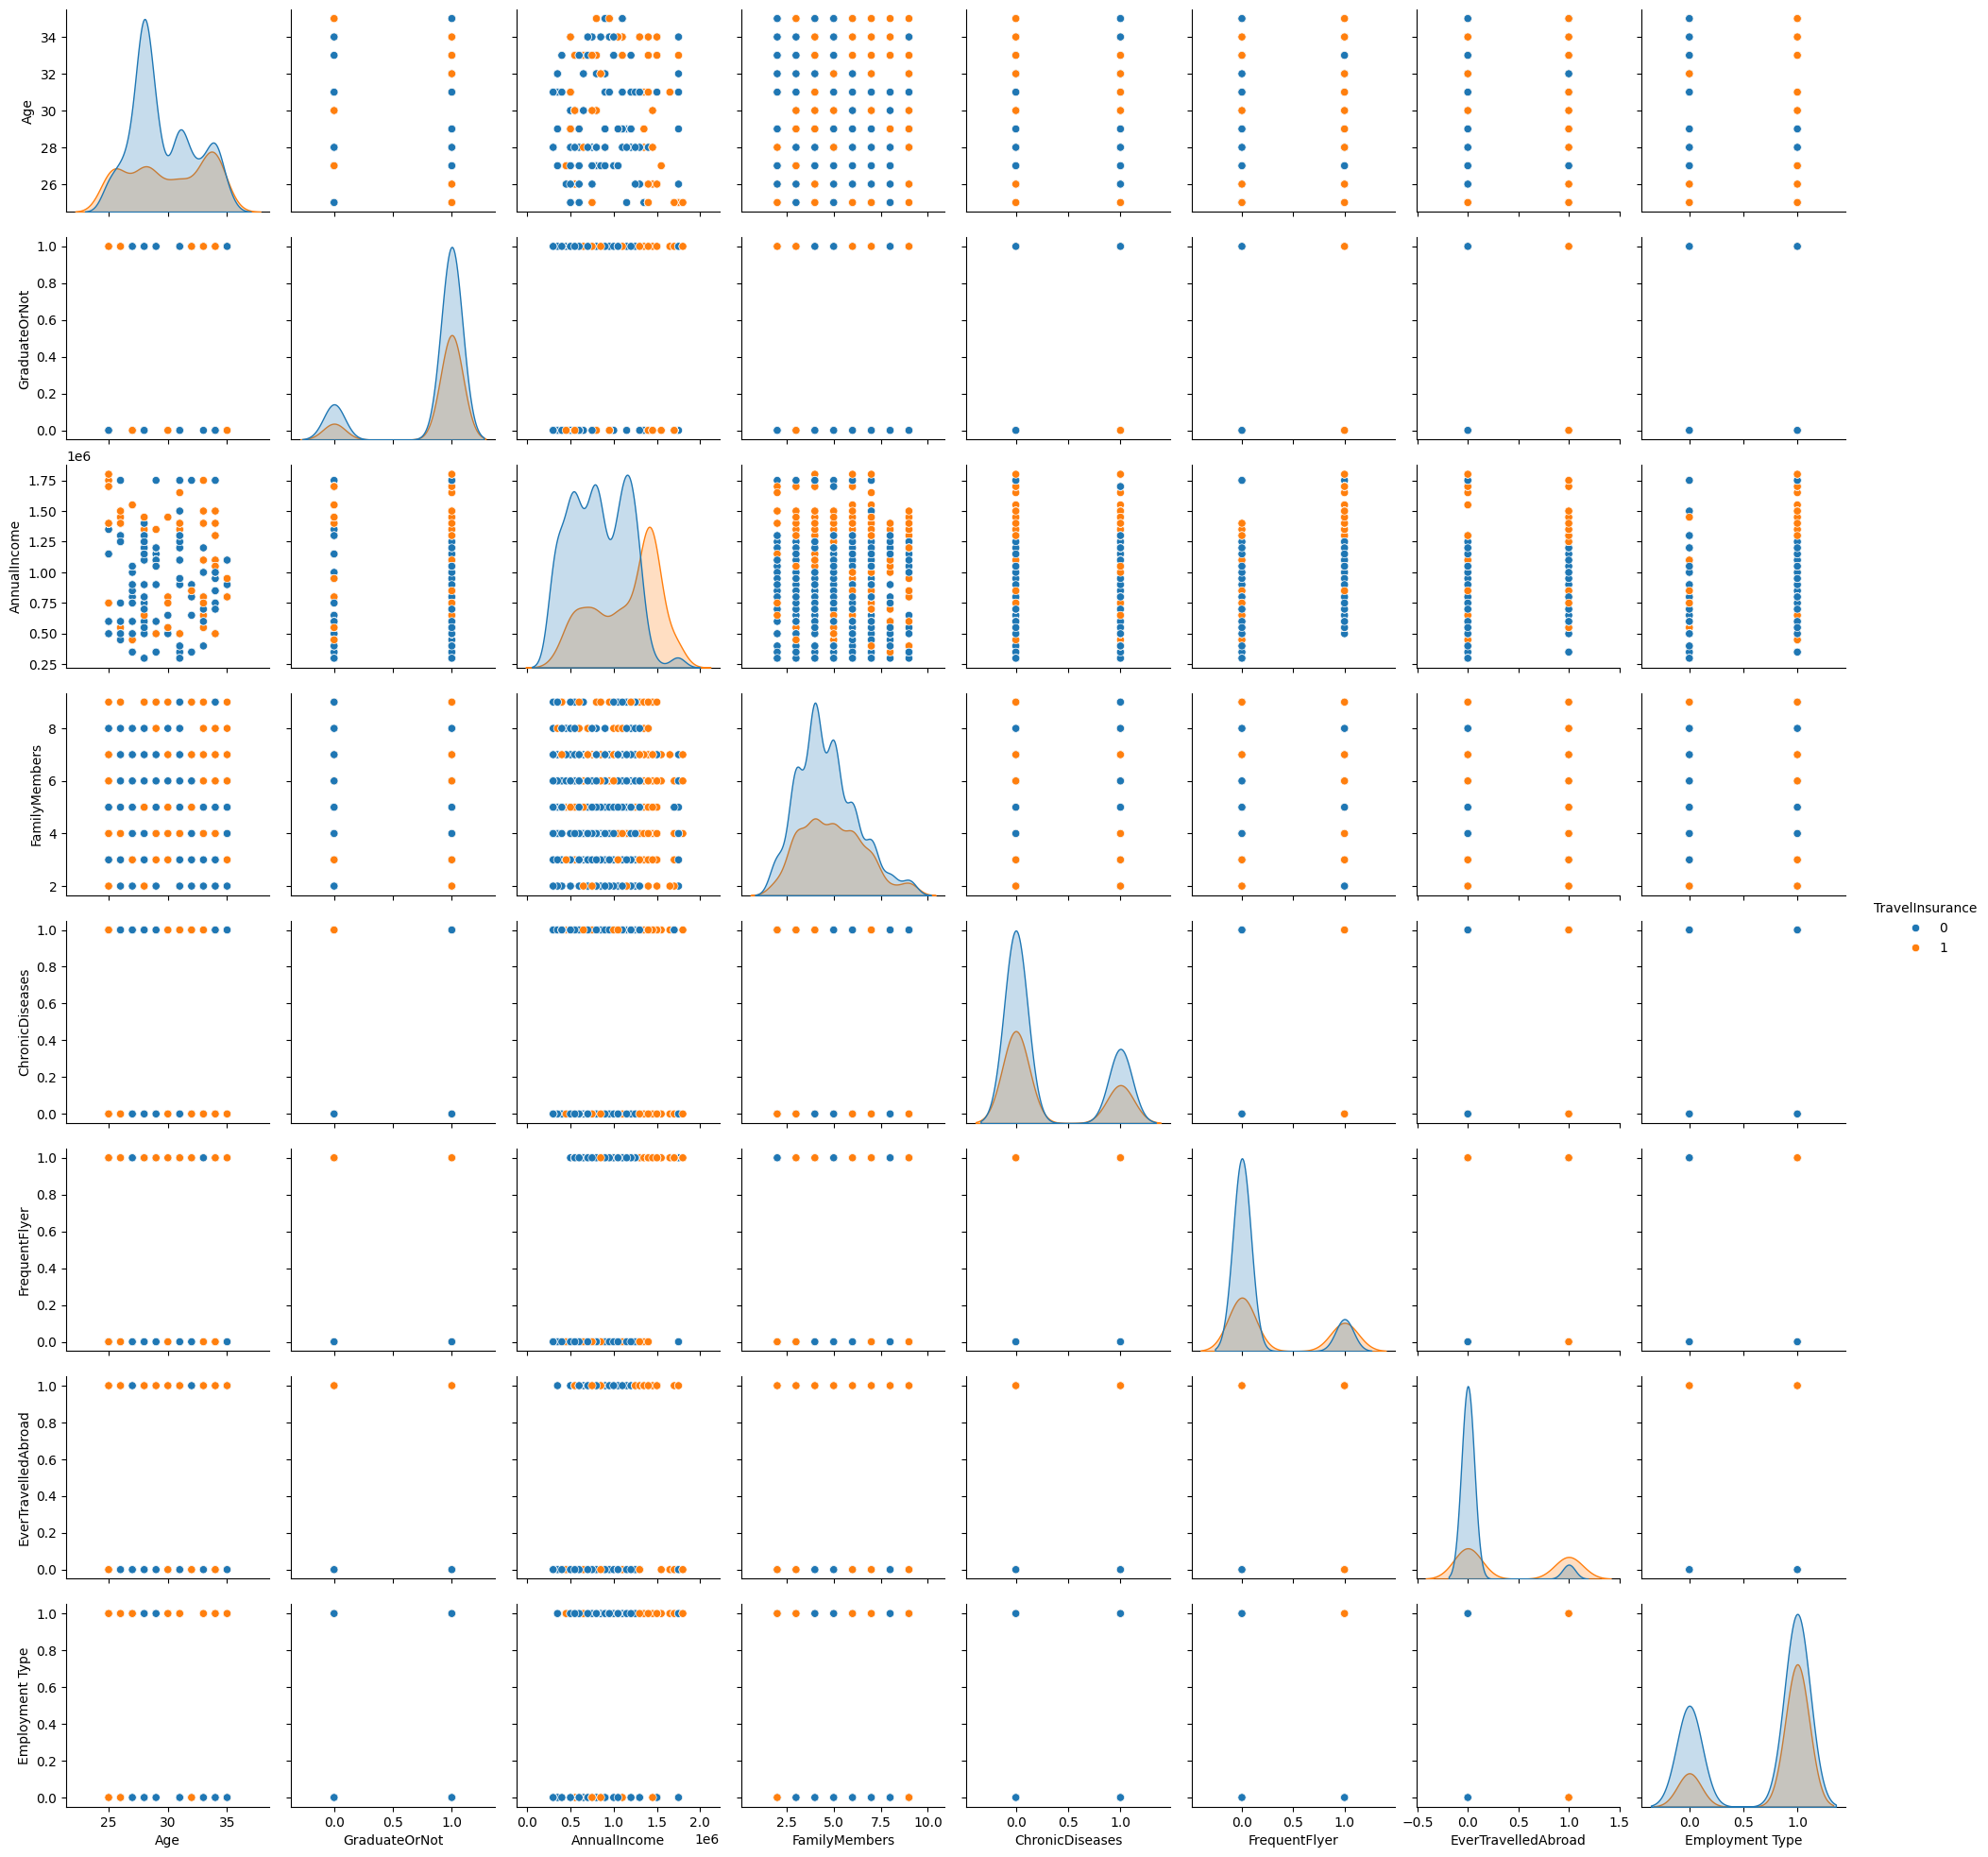

In [9]:
data_for_visualization = train_data.copy()
variable_space = data_for_visualization.columns
variable_space_wo_employment = variable_space.drop(['Employment Type'])
variable_space = variable_space.drop(['TravelInsurance'])

le = LabelEncoder()
le.fit(['No', 'Yes'])
for col in data_for_visualization[variable_space_wo_employment].select_dtypes(['object']):
    data_for_visualization[col] = le.transform(data_for_visualization[col])

le2 = LabelEncoder()
data_for_visualization['Employment Type'] = le2.fit_transform(data_for_visualization['Employment Type'])

sns.pairplot(data_for_visualization[[*variable_space_wo_employment, 'Employment Type']],
                hue = 'TravelInsurance');

Couple of findings of note:
- Much more of the clients that are in the dataset have Graduate degrees.
- According to the graph, more high-income-earning customers were purchasing travel insurance - perhaps, a clue.
- Most of the clients that we have in the dataset have not Ever Travelled Abroad. It could just be because they only fly within their own country. 
- It seems as though clients with higher amounts of family members & with more AnnualIncome purchase Travel Insurance more. This only makes sense.
- Clients that have Travelled Aborad before seem to be more keen in buying Travel Insurance. 

What if take a look at how to combinations plan out if we plotted them on cross tab plots?

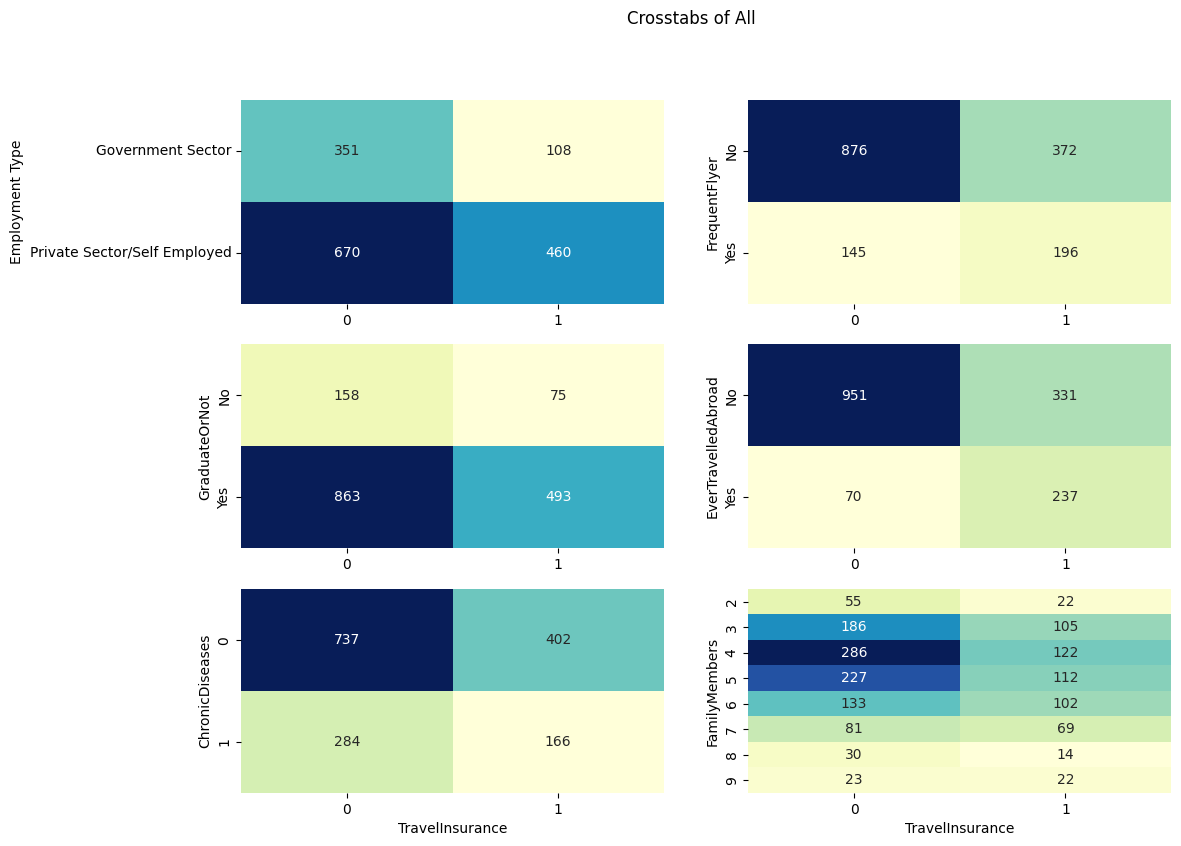

In [10]:
fig, ax = plt.subplots(3, 2, figsize = (12, 9))

for i, col in enumerate([*categorical_variables, 'FamilyMembers']):

    column = i % 3
    row = i // 3

    ct = pd.crosstab(train_data[col], train_data['TravelInsurance'])
    sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax = ax[column][row])
    if column != 2:
        ax[column][row].set_xlabel('')

fig.suptitle('Crosstabs of All')
plt.show()

Well, this is certainly interesting! Firstly, it seems that customers that work in the Private Sector or which are Self Employed generally prop up more often in the dataset. It also seems that non-FrequentFlyers are the ones that do not get the Travel Insurance on average. Perhaps they can not afford it as they cannot afford frequent plane travel as well?

The same goes for clients that have not Travelled Abroad -> they much more prefer not taking Travel Insurance. Could this also be related to the fact that they might only partake in Domestic travel? This could make them much more sure of the potential dangers and thus not taking travel insurance? On the contrary, people that have been abroad tend to be fond(er) of Travel Insurance compared to their counterparts that have not been abroad.

Not sick by Chronic Diseases people tend to not take travel insurance as well. I can't really understand why though. Perhaps they are correlated with `EverTravelledAbroad` people as well. 
Chronic Disease-riddled people do take Travle Insurance more though.

Lastly, if we look at Family Matters - the more people have family members, the less they are inclined to actually partake in travel insurance purchases. This is evident on every level of number of family members too.


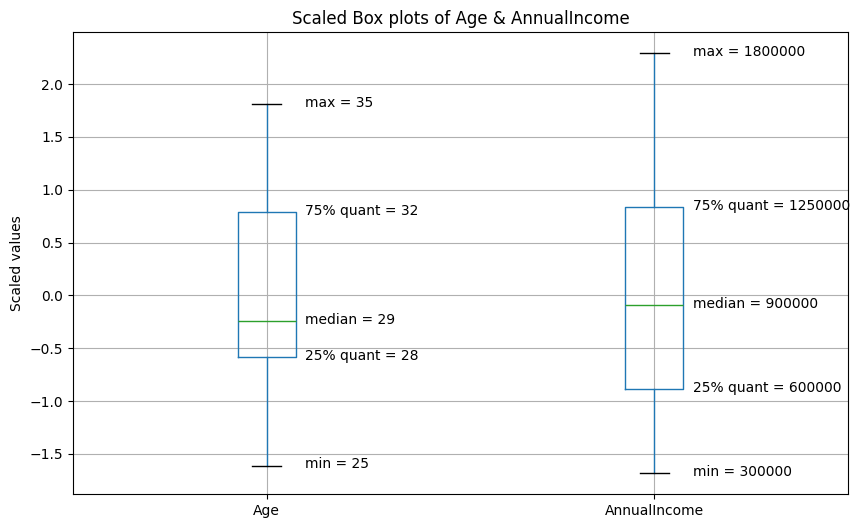

In [11]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(train_data[numeric_variables]),
                           columns = numeric_variables)

scaled_data.boxplot(figsize=(10, 6))

plt.title('Scaled Box plots of Age & AnnualIncome')
plt.ylabel('Scaled values')
plt.text(x = 2.1,
         y = scaled_data['AnnualIncome'].median()-0.025,
         s = f"median = {data.AnnualIncome.median():.0f}");
plt.text(x = 1.1,
         y = scaled_data['Age'].median()-0.025,
         s = f"median = {data.Age.median():.0f}");
plt.text(x = 2.1,
         y = scaled_data['AnnualIncome'].max()-0.025,
         s = f"max = {data.AnnualIncome.max():.0f}");
plt.text(x = 1.1,
         y = scaled_data['Age'].max()-0.025,
         s = f"max = {data.Age.max():.0f}");
plt.text(x = 2.1,
         y = scaled_data['AnnualIncome'].min()-0.025,
         s = f"min = {data.AnnualIncome.min():.0f}");
plt.text(x = 1.1,
         y = scaled_data['Age'].min()-0.025,
         s = f"min = {data.Age.min():.0f}");
plt.text(x = 2.1,
         y = scaled_data['AnnualIncome'].quantile(0.75)-0.025,
         s = f"75% quant = {data.AnnualIncome.quantile(0.75):.0f}");
plt.text(x = 1.1,
         y = scaled_data['Age'].quantile(0.75)-0.025,
         s = f"75% quant = {data.Age.quantile(0.75):.0f}");
plt.text(x = 2.1,
         y = scaled_data['AnnualIncome'].quantile(0.25)-0.025,
         s = f"25% quant = {data.AnnualIncome.quantile(0.25):.0f}");
plt.text(x = 1.1,
         y = scaled_data['Age'].quantile(0.25)-0.025,
         s = f"25% quant = {data.Age.quantile(0.25):.0f}");


This just underlines the fact that our `Age` range is relatively small and out AnnualIncome distribution is quite wide (between the min and the max there is a 6x differnce). Whilst this might not be directly pointing to an unbalanced dataset, this could be hinting at the clientele being quite diverse in terms of incomes (and perhaps, thus, the company diverse in it's product offering). Lastly, let's just make sure that we have no overarching multicollinearity in our future dataset.

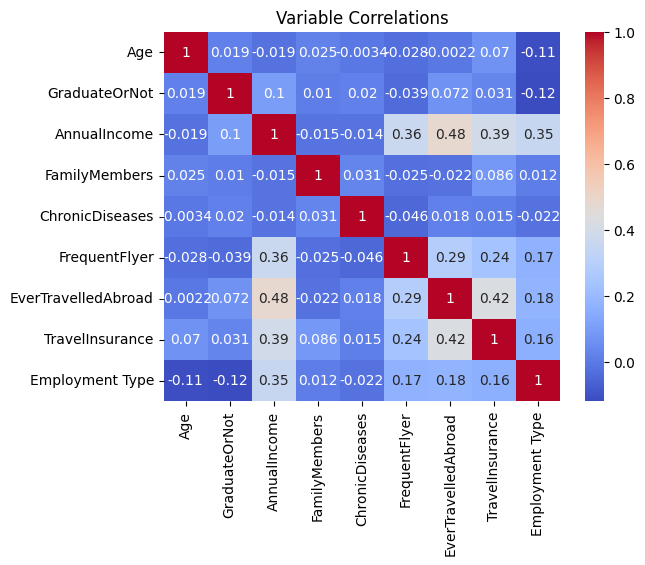

In [12]:
correlation_matrix = data_for_visualization[[*variable_space_wo_employment, 'Employment Type']].corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot = True)
plt.title('Variable Correlations');

There seems to not be any correlations that should tip us off. So, let's proceed.

# Model Development

The philosophy behind the model development for this particular project is that we will look at all plausibly usable models that can be fitted to the training data that we have and then see which ones yield the highest performance. 

These will be the models that we build:
- Logistic Regression
- Decision Tree Classifier
- Support Vector Classifier
- K-Nearest Neighbors Classifier
- Random Forest Classifier
- Gradient Boosting Classifier
- Multi-Layer Perceptron

Whilst the choice of performance metric is contentious, I will be choosing `Recall` as the main performance metric by which to rank the models in terms of performance. The reason for this decision is that logically speaking the company that would be interested in this modelling process would prefer to have *as many potential clients returned as possible, regardless of how many it gets that are not as interested in travel insurance*.

Additionally, the first phase testing will be done on the Validation dataset so that each model would have the same baseline for comparison.

## Baseline - Dummy Classifier

But first - let's establish what a baseline model would look like without any decision logic implemented:

In [13]:
categorical_preprocessor =  OneHotEncoder(dtype='int',
                                          sparse_output=False).set_output(transform="pandas")
preprocessor = ColumnTransformer(
                    [('categories', categorical_preprocessor, categorical_variables)],
                    remainder = StandardScaler(), verbose_feature_names_out=False)
models = {}

Results for Dummy Classifier model:
Accuracy: 0.6432160804020101
Precision: 0.0
Recall: nan


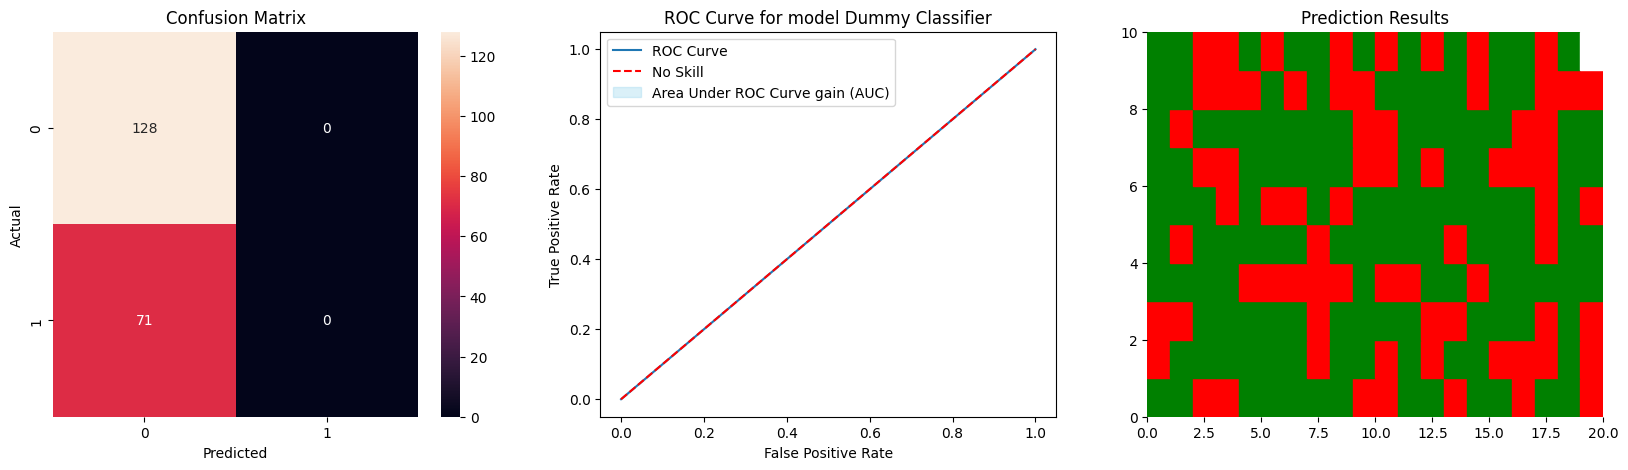

In [14]:
dummy_model = make_pipeline(preprocessor, DummyClassifier())

dummy_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = dummy_model.predict(validation_data[variable_space])
validation_probabilities = dummy_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'Dummy Classifier');

Here we can see that the Dummy Classifier is quite bad - it's precision is 0, because it just predicted the most common group (TravelInsurance = 0). It also has no benefit in terms of recall (again, because it is only predicting the negative class). I guess we can only go up?

##  Logistic Regression

Results for LogisticRegression model:
Accuracy: 0.7638190954773869
Precision: 0.4788732394366197
Recall: 0.7727272727272727


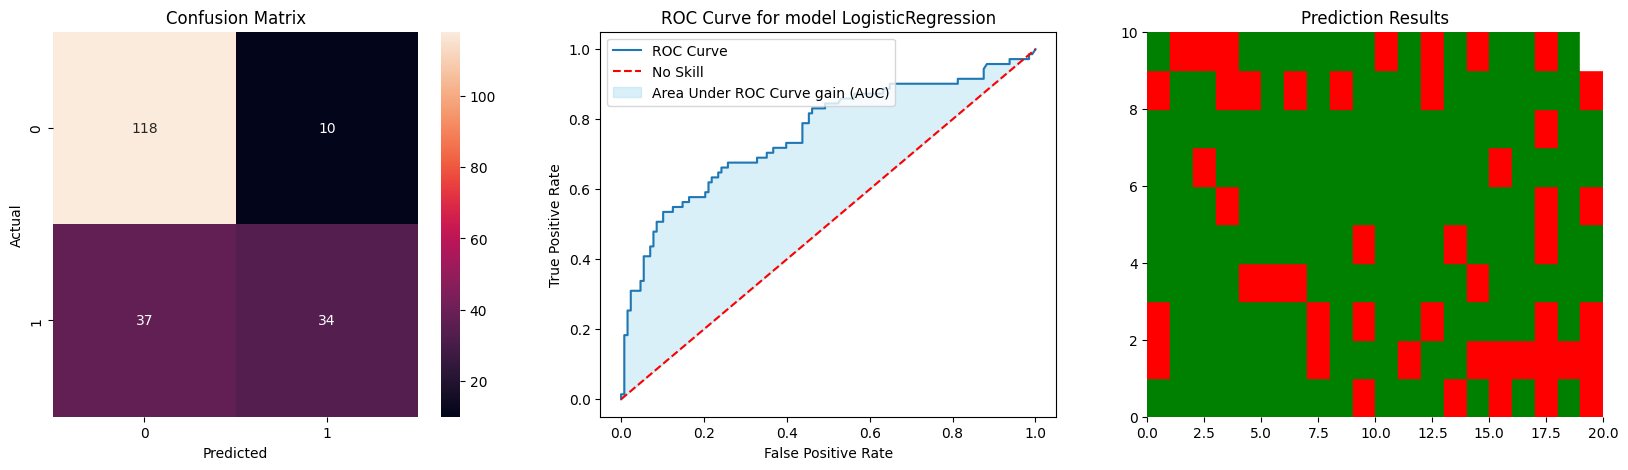

In [15]:
logistic_regression_model = make_pipeline(preprocessor, LogisticRegression())

logistic_regression_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = logistic_regression_model.predict(validation_data[variable_space])
validation_probabilities = logistic_regression_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'LogisticRegression')
models['LogisticRegression'] = logistic_regression_model

The Logistic Regression actually gives us quite a significant boost in our predictive capabilities - our recall is now ~0.77, but our Precision is only `~0.48`.
It was able to predict 152 out of 199 predictions correct.

There's also much less red blocks on the graph on the right as well.

## Decision Tree Classifier

Results for DecisionTreeClassifier model:
Accuracy: 0.8190954773869347
Precision: 0.5352112676056338
Recall: 0.926829268292683


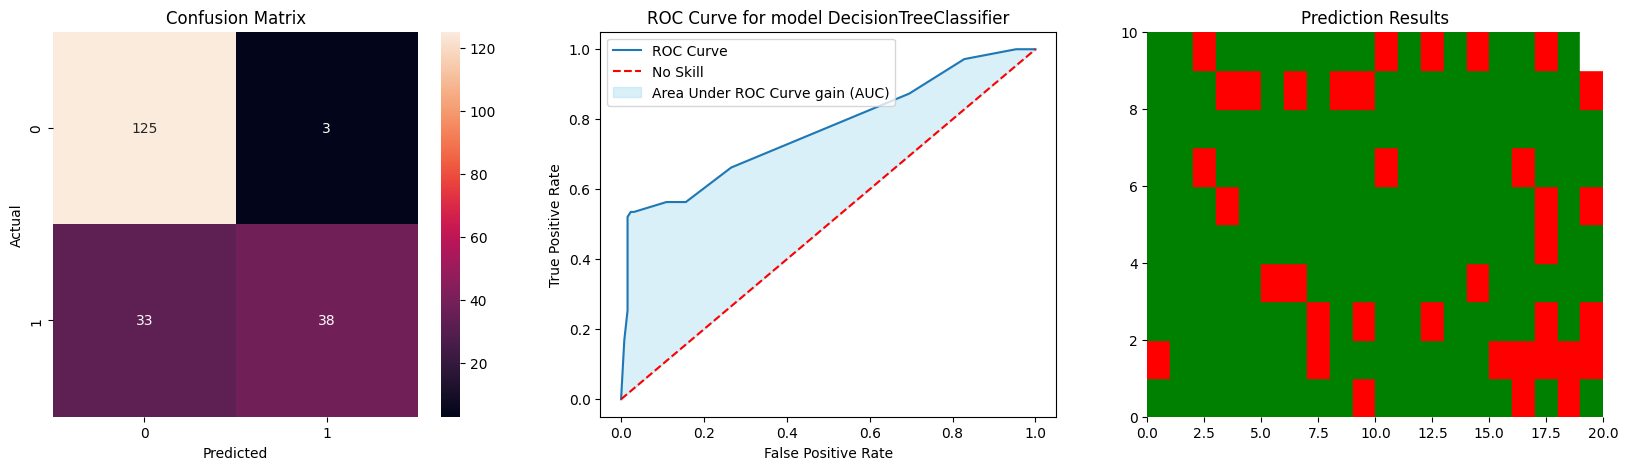

In [16]:
decision_tree_model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=5))

decision_tree_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = decision_tree_model.predict(validation_data[variable_space])
validation_probabilities = decision_tree_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'DecisionTreeClassifier')
models['DecisionTreeClassifier'] = decision_tree_model

The Decision Tree Classifier Regression actually performs extremely well right off the bat - our recall is now ~0.93, and our Precision is `~0.54`.
It was able to predict 163 (+11 more) out of 199 predictions correct.

There's even less red blocks on the graph on the right as well. However, notice that the decision tree is only 5 levels deep - we have set it up that way. Later on, we can even prune the tree more.

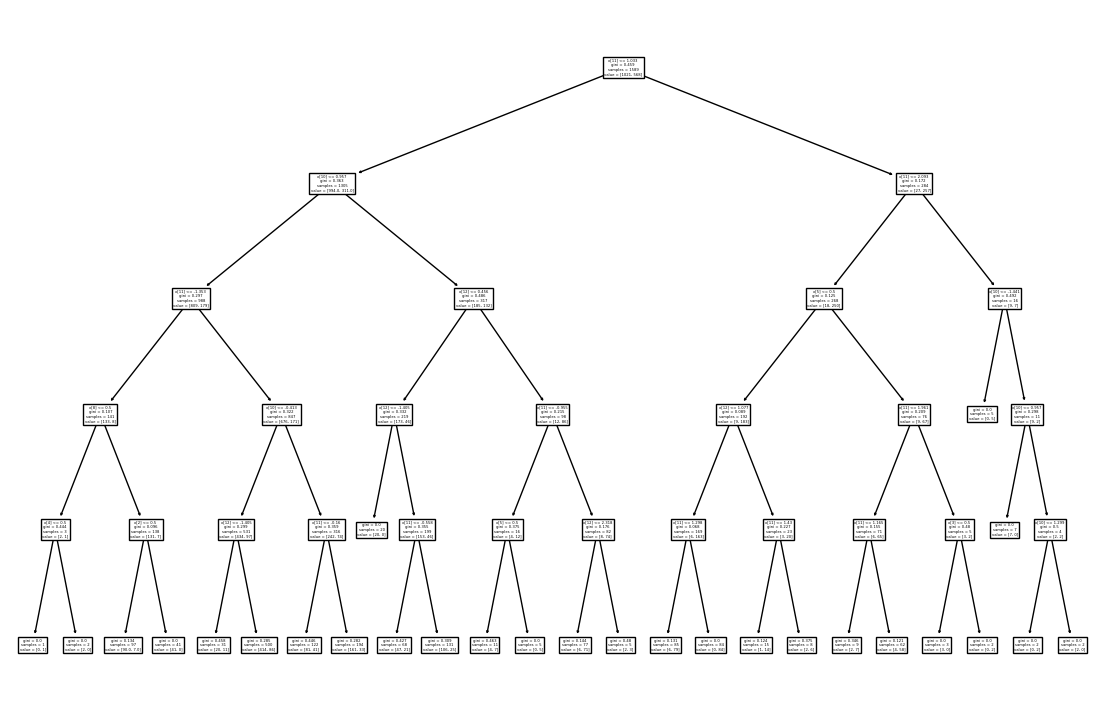

In [17]:
fig = plt.figure(figsize = (14, 9))
plot_tree(decision_tree_model.named_steps['decisiontreeclassifier']);

## Support Vector Machine

Results for SVC model:
Accuracy: 0.8090452261306532
Precision: 0.5492957746478874
Recall: 0.8666666666666667


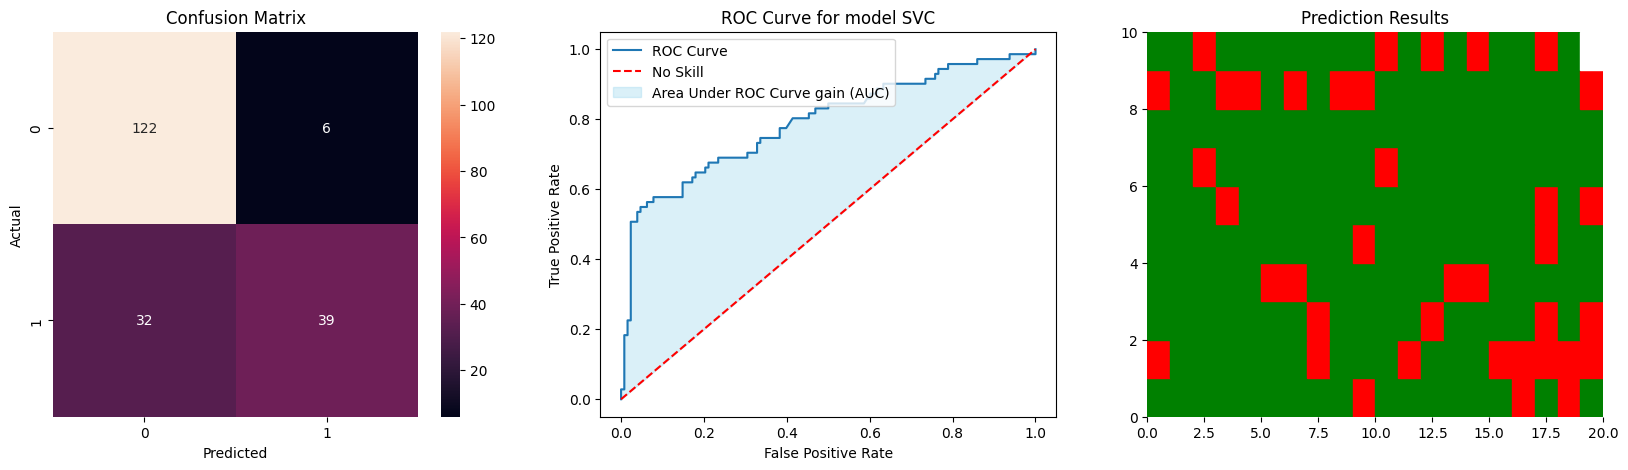

In [18]:
SVC_model = make_pipeline(preprocessor, SVC(probability=True, random_state=12))

SVC_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = SVC_model.predict(validation_data[variable_space])
validation_probabilities = SVC_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'SVC')
models['SVC'] = SVC_model

The base support vector classifier actually outperforms the Logistic Regression as well. The `Recall` is `~0.87` & our precision is `~0.55` (actually even better than the Decision Tree). It was able to predict 161 out of 199 correctly. What about k-NearestNeighbors?

## K-Nearest Neighbors

Results for KNearestNeighborsClassifier model:
Accuracy: 0.7537688442211056
Precision: 0.5211267605633803
Recall: 0.7115384615384616


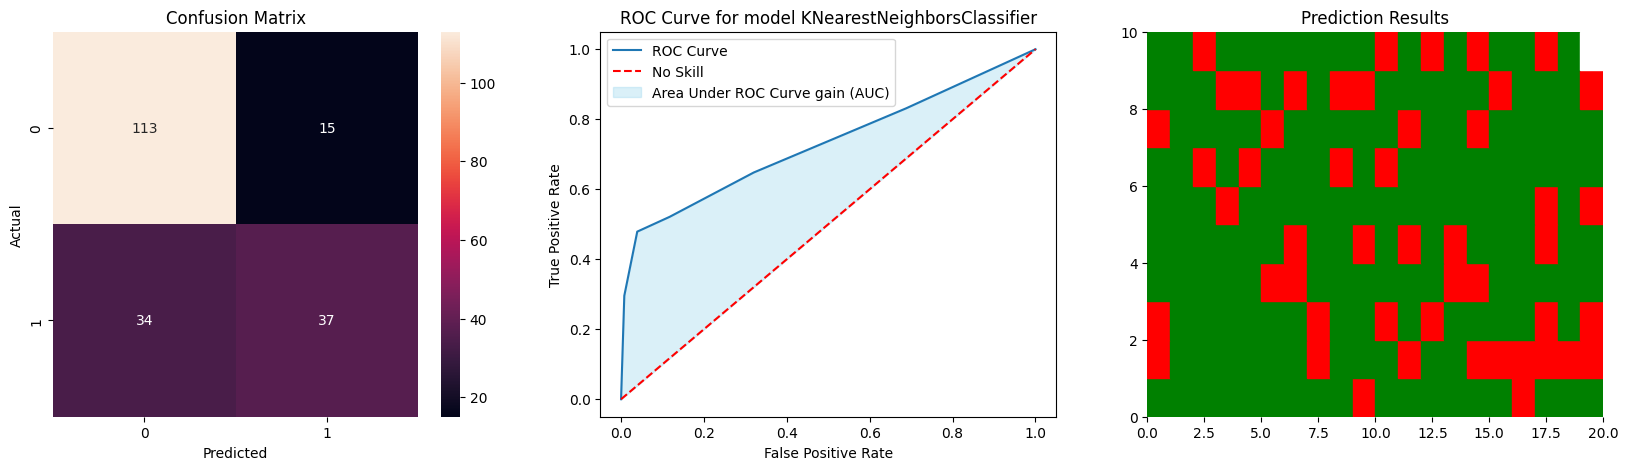

In [19]:
KNN_model = make_pipeline(preprocessor, KNeighborsClassifier())

KNN_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = KNN_model.predict(validation_data[variable_space])
validation_probabilities = KNN_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'KNearestNeighborsClassifier')
models['KNearestNeighborsClassifier'] = KNN_model

The KNN classifier didn't perform that well to be honest. Currently, it's pretty much on par with the Logistic Regression classifier. It was able to predict only 150 out of 199 possible clients correct. However, this might be because it's just not tuned and currently it's only taking 5 nearest neighbors and making the decision. Maybe it needs more?

## Random Forest Classifier

Results for RandomForestClassifier model:
Accuracy: 0.7939698492462312
Precision: 0.6197183098591549
Recall: 0.7586206896551724


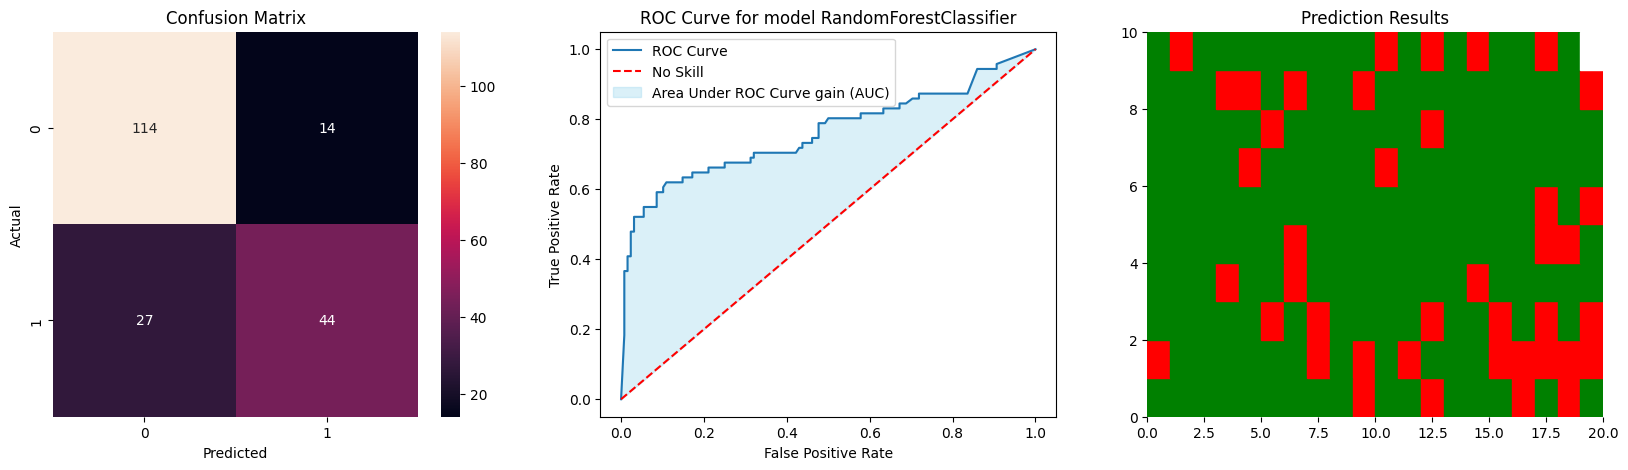

In [20]:
random_forest_model = make_pipeline(preprocessor, RandomForestClassifier())

random_forest_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = random_forest_model.predict(validation_data[variable_space])
validation_probabilities = random_forest_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'RandomForestClassifier')
models['RandomForestClassifier'] = random_forest_model

Now we move to the Ensembles. Firstly, the Gradient Boosting Classifier seems to actually be quite good out of the box - the recall seems to be quite high & the precision is one of the highest so far too. It correctly predicted 157 predicitions out of 199 (maybe not that great). 

However, different predictions are now wrong & right compared to previously if we take a look at the right-most graph - perhaps this is a good indicator for higher ensemble methods that encompass multiple models as a potentially good solution. *wink* *wink*

## Gradient Boosting Classifier

Results for GradientBoostingClassifier model:
Accuracy: 0.8190954773869347
Precision: 0.5352112676056338
Recall: 0.926829268292683


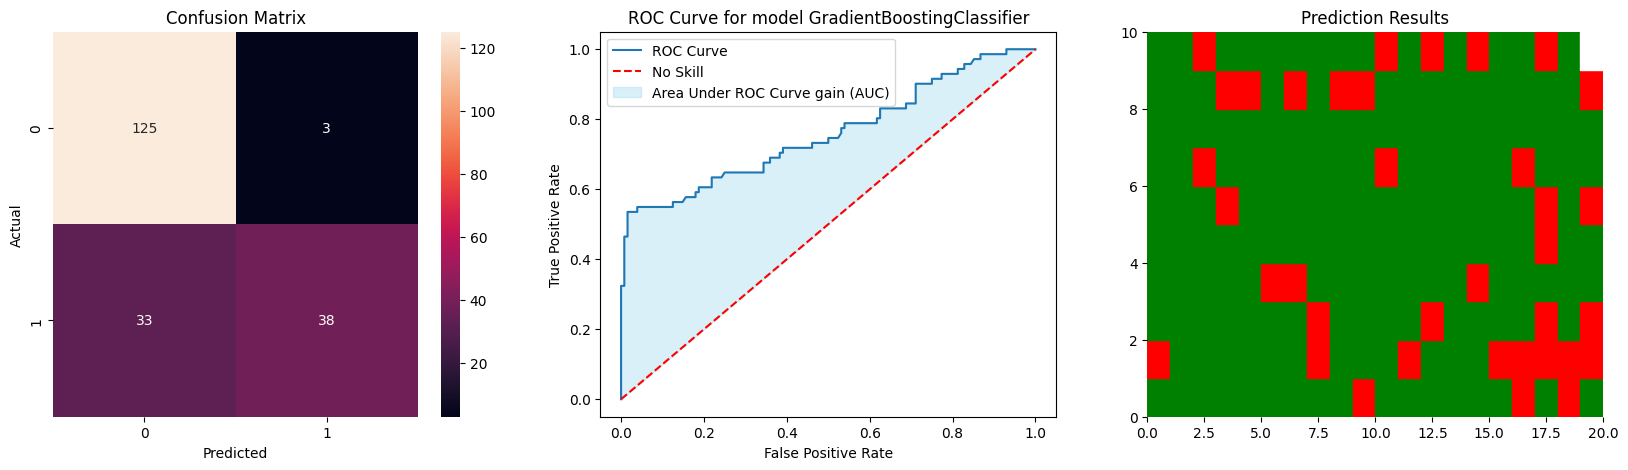

In [21]:
gradient_boosting_model = make_pipeline(preprocessor, GradientBoostingClassifier())

gradient_boosting_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = gradient_boosting_model.predict(validation_data[variable_space])
validation_probabilities = gradient_boosting_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'GradientBoostingClassifier')
models['GradientBoostingClassifier'] = gradient_boosting_model

Gradient Boosting Model is also one of the best models as well - it boasts a `~0.926` recall value and a `~0.535` precision score - both not bad scores. It was able to predict 163 out of 199 clients correct. Even the ROC curve is showing that it seems to be a good candidate for a model 

## Neural Network - Multi-Layer Perceptron

c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Results for MultiLayerPerceptron model:
Accuracy: 0.7939698492462312
Precision: 0.5633802816901409
Recall: 0.8


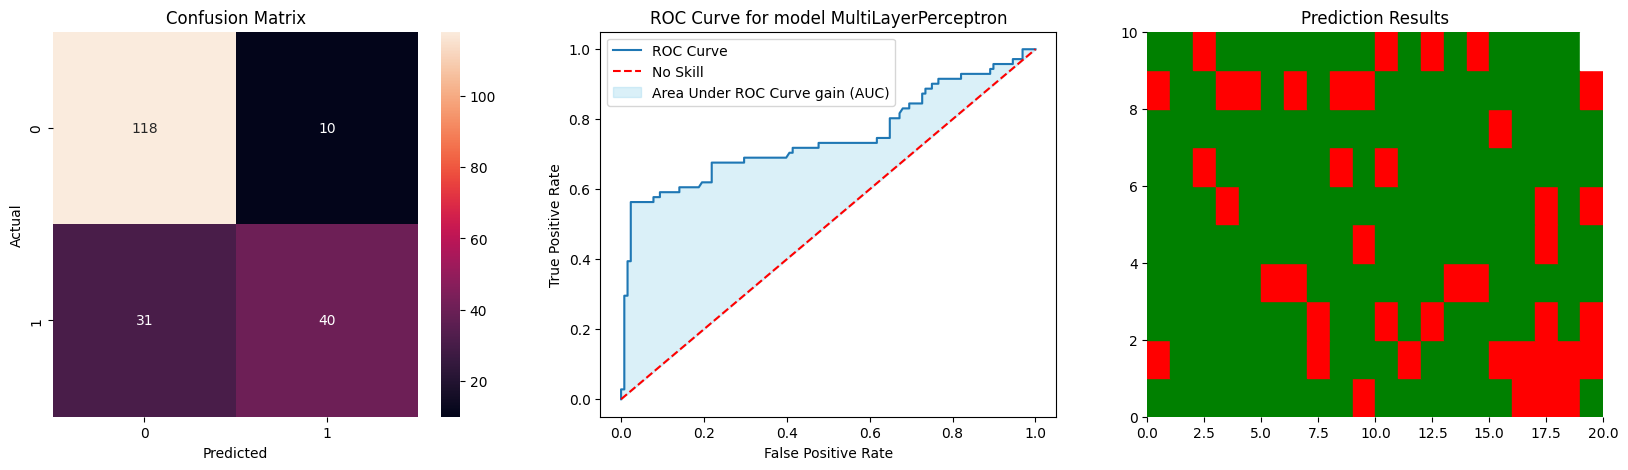

In [22]:
multi_layer_perceptron = make_pipeline(preprocessor, MLPClassifier())

multi_layer_perceptron.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = multi_layer_perceptron.predict(validation_data[variable_space])
validation_probabilities = multi_layer_perceptron.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'MultiLayerPerceptron')
models['MultiLayerPerceptron'] = multi_layer_perceptron

Lastly, we have the Multi-layer perceptron (the neural network). It's values are quite good too. However, I believe it's a bit too difficult to tune compared to the other models. Therefore, we will not be moving with this model furhther. 

## Cross Validation

Up until now we have only looked at one split of the data to validate as to what the true predictive capabilities are for each model fitted with our data. But that is not a really representative sample, right? Why don't we cross validate each model and bring back the average results starting with...

### Logistic Regression

In [23]:
log_reg_cv = cross_validate(logistic_regression_model,
                            train_data[variable_space],
                            train_data[target_variable_column],
                            scoring = ['recall', 'precision'],
                            cv = 10,
                            n_jobs = 2)

print(f"Average Recall {log_reg_cv['test_recall'].mean()}")
print(f"Average Precision {log_reg_cv['test_precision'].mean()}")

Average Recall 0.4700187969924812
Average Precision 0.7645015296566857


The Logistic Regression Model was actully pretty correct - nothing much has changed.

### Decision Tree Classifier

In [24]:
decision_tree_cv = cross_validate(decision_tree_model,
                                        train_data[variable_space],
                                        train_data[target_variable_column],
                                        scoring = ['recall', 'precision'],
                                        cv = 10,
                                        n_jobs = 2
)

print(f"Average Recall {decision_tree_cv['test_recall'].mean()}")
print(f"Average Precision {decision_tree_cv['test_precision'].mean()}")

Average Recall 0.588001253132832
Average Precision 0.9078763704333346


Now, DecisionTreeClassifier results have gone down a bit, but they are still very good. However, remember, that we are particularly looking at recall.

### Support Vector Classifier

In [25]:
SVC_model_vc = cross_validate(SVC_model,
                                train_data[variable_space],
                                train_data[target_variable_column],
                                scoring = ['recall', 'precision'],
                                cv = 10,
                                n_jobs = 2
)

print(f"Average Recall {SVC_model_vc['test_recall'].mean()}")
print(f"Average Precision {SVC_model_vc['test_precision'].mean()}")

Average Recall 0.5861528822055139
Average Precision 0.8613807900771574


Support Vector Classifier seems to be on the same level as the Decision Tree Classifier, just a bit poorer in terms of precision. 

### K-Nearest Neighbors

In [26]:
KNN_model_vc = cross_validate(KNN_model,
                                train_data[variable_space],
                                train_data[target_variable_column],
                                scoring = ['recall', 'precision'],
                                cv = 10,
                                n_jobs = 2
)

print(f"Average Recall {KNN_model_vc['test_recall'].mean()}")
print(f"Average Precision {KNN_model_vc['test_precision'].mean()}")

Average Recall 0.6072994987468671
Average Precision 0.7564394277495683


The K-Nearest Neighbors model is poorer on average too (something similar to the Logistic Regression Model)

### Random Forest Model

In [27]:
random_forest_model_vc = cross_validate(random_forest_model,
                                train_data[variable_space],
                                train_data[target_variable_column],
                                scoring = ['recall', 'precision'],
                                cv = 10,
                                n_jobs = 2
)

print(f"Average Recall {random_forest_model_vc['test_recall'].mean()}")
print(f"Average Precision {random_forest_model_vc['test_precision'].mean()}")

Average Recall 0.6442669172932332
Average Precision 0.7688524253524254


In terms of the Random Forest Model, the Recall is actually the best compared to all the other models.

### Gradient Boosting Classifier

In [28]:
gradient_boosting_model_vc = cross_validate(gradient_boosting_model,
                                train_data[variable_space],
                                train_data[target_variable_column],
                                scoring = ['recall', 'precision'],
                                cv = 10,
                                n_jobs = 2
)

print(f"Average Recall {gradient_boosting_model_vc['test_recall'].mean()}")
print(f"Average Precision {gradient_boosting_model_vc['test_precision'].mean()}")

Average Recall 0.600344611528822
Average Precision 0.9078816825482552


Gradient Boosting Classifier also seems to be quite a good option. We will be taking this model forward as well.

### Multi-Layer Perceptron

In [29]:
multi_layer_perceptron_vc = cross_validate(multi_layer_perceptron,
                                train_data[variable_space],
                                train_data[target_variable_column],
                                scoring = ['recall', 'precision'],
                                cv = 10,
                                n_jobs = 2
)

print(f"Average Recall {multi_layer_perceptron_vc['test_recall'].mean()}")
print(f"Average Precision {multi_layer_perceptron_vc['test_precision'].mean()}")

Average Recall 0.6020989974937343
Average Precision 0.8469081591492553


Let's choose the best models (in terms of recall) to go forward with: the `Gradient Boosting Classifier`, the `Random Forest Classifier` & the `Logistic Regression` (just because it's a staple).

## Hyperparameter Tuning

Now that we have chosen the best out of the box models, let's proceed with hyperparameter tuning for each of them to see which one would have the best Recall.

### Logistic Regression

Let's start off with the Logistic Regression Model. The hyperparameters that we will be tuning to maximize Recall are:
- C - Inverse of regularization strength
- tol - Tolerance for stopping criteria
- solver - Algorithm to use in the optimization problem. One between 'lbfgs', 'liblinear', 'saga'

The way we'll be performing RandomizedSearchCV - function for Randomized Hyperparameter tuning. Both the `C` and the `tol` hyperparameters will be pulled from a loguniform distribution. This distribution prefers smaller values as opposed to very extreme ones.

In [30]:
log_regression_param_distributions = {
    "logisticregression__C": loguniform(1e-6, 1000),
    "logisticregression__tol": loguniform(1e-6, 1000),
    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga']
}

In [31]:
# %%time
best_logregression_estimator, cv_results = fn.cross_validation_setup(models['LogisticRegression'],
                          log_regression_param_distributions,
                          train_data,
                          variable_space,
                          target_variable_column)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Model Hyperparameters: {'logisticregression__C': 0.01422205456669046, 'logisticregression__solver': 'lbfgs', 'logisticregression__tol': 0.05458054254078434}
Best Model Recall Score: 0.4929203539823009


The recall actually was not even that much improved.

The best `C` metric ended up being `~0.020913`.
The best `solver` ended up being `saga`.
The best `tol` metric ended up being `~0.09287`.

Let's look at the how these hyperparameters shake up with regards to the model `mean test results` 

In [32]:
cv_results['C'] = cv_results['C'].apply(lambda x: loguniform(1e-6, 1e3).rvs())
cv_results['tol'] = cv_results['tol'].apply(lambda x: loguniform(1e-6, 1e3).rvs())

fig = px.parallel_coordinates(
    cv_results[['C', 'tol', 'mean_test_score']],
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(title = 'Parallel Coordinates for Logistic Regression',
                  title_x=0.5,
                  title_y=0.05,
                  width=1400, height=600)
fig.show()

According to this graph, high values of C & tol create relatively lower values of recall scores. Makes sense why the algorithm chose such small values. Now let's look at the performance metrics of this best logistic regression estimator model.

Results for LogisticRegression model:
Accuracy: 0.7688442211055276
Precision: 0.49295774647887325
Recall: 0.7777777777777778


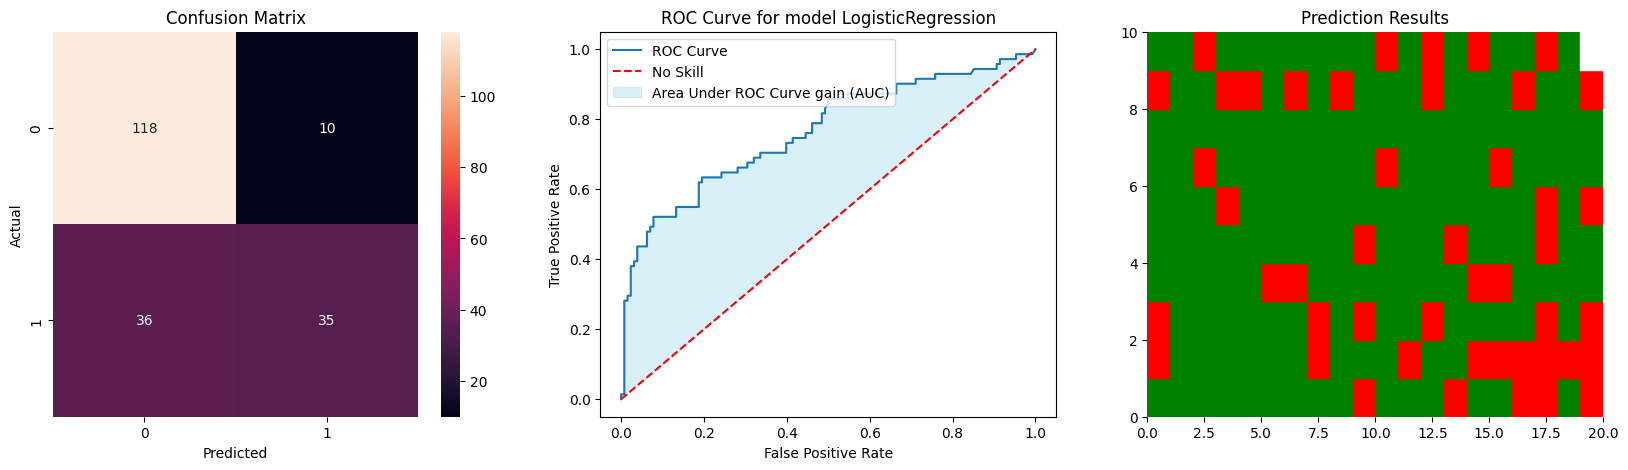

In [33]:
validation_predictions = best_logregression_estimator.predict(validation_data[variable_space])
validation_probabilities = best_logregression_estimator.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'LogisticRegression')

It seems that the model was actually greatly improved. Now it has a recall of around 0.767 (+~0.3 increase) from the cross-validated results. It can still predict 151 (-1 change) values correctly. The ROC Curve was also higher as well.

### Gradient Boosting Classifier

The hyperparameters that we will be tuning to maximize Recall are:
- Learning Rate - Learning rate shrinks the contribution of each tree by learning_rate. 
- Loss - The loss function to be optimized. One between 'log_loss', 'exponential'
- Max Depth - Maximum depth of the individual regression estimators
- Max Leaf Notes - Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.
- Min Samples Leaf - The minimum number of samples required to be at a leaf node.
- N estimators - The fraction of samples to be used for fitting the individual base learners.
- Tol - Tolerance for the early stopping. When the loss is not improving by at least tol for n_iter_no_change iterations (if set to a number), the training stops


The `learning_rate`, `tol` hyperparameters will be pulled from a loguniform distribution, whilst `max_depth`, `max_leaf_nodes`, `min_samples_leaf`, `n_estimators` are pulled from a randint distribution. The `lognormal` distribution prefers smaller values as opposed to very extreme ones.

In [34]:
gradient_boosting_param_distributions = {
    "gradientboostingclassifier__learning_rate": loguniform(1e-6, 10),
    "gradientboostingclassifier__loss": ['log_loss','exponential'],
    "gradientboostingclassifier__max_depth": randint(2, 4),
    "gradientboostingclassifier__max_leaf_nodes" : randint(2, 9),
    "gradientboostingclassifier__min_samples_leaf" : randint(2, 6),
    "gradientboostingclassifier__n_estimators" : randint(100, 1000),
    "gradientboostingclassifier__tol" : loguniform(1e-6, 1e3),
}

In [35]:
# %%time
best_gradientboosting_estimator, cv_results = fn.cross_validation_setup(
                                                models['GradientBoostingClassifier'],
                                                gradient_boosting_param_distributions,
                                                train_data,
                                                variable_space,
                                                target_variable_column,
                                                10)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Model Hyperparameters: {'gradientboostingclassifier__learning_rate': 0.5166281738291468, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__max_leaf_nodes': 3, 'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__n_estimators': 872, 'gradientboostingclassifier__tol': 3.0151731396473537e-05}
Best Model Recall Score: 0.6301040211147336


The recall actually was not even that much improved.

The best `learning_rate` metric ended up being `~0.5166`.

The best `loss` ended up being `exponential`.

The best `max_depth` metric ended up being `2`.

The best `max_leaf_nodes` metric ended up being `3`.

The best `min_samples_leaf` metric ended up being `2`.

The best `n_estimators` metric ended up being `872`.

The best `tol` metric ended up being `~3.0152`.


Let's look at the how these hyperparameters shake up with regards to the model `mean test results` 

In [36]:
cv_results['learning_rate'] = cv_results['learning_rate'].apply(lambda x: loguniform(1e-6, 10).rvs())
cv_results['max_depth'] = cv_results['max_depth'].apply(lambda x: randint(2, 4).rvs())
cv_results['max_leaf_nodes'] = cv_results['max_leaf_nodes'].apply(lambda x: randint(2, 9).rvs())
cv_results['min_samples_leaf'] = cv_results['min_samples_leaf'].apply(lambda x: randint(2, 6).rvs())
cv_results['n_estimators'] = cv_results['n_estimators'].apply(lambda x: randint(100, 1000).rvs())
cv_results['tol'] = cv_results['tol'].apply(lambda x: loguniform(1e-6, 1e3).rvs())

In [37]:
fig = px.parallel_coordinates(
    cv_results[['learning_rate',
                'max_depth',
                'max_leaf_nodes',
                'min_samples_leaf',
                'n_estimators',
                'tol',
                'mean_test_score']],
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(title = 'Parallel Coordinates for Logistic Regression',
                  title_x=0.5,
                  title_y=0.05,
                  width=1400, height=600)
fig.show()

According to this graph, there are several combinations of hyperparameters that lead to good results on the Gradient Boosting model in terms of recall. This just makes sense with the nature of the hyperparameters being contrary to each other.

Now let's look at the performance metrics of this best gradient boosting model.

Results for GradientBoostingClassifier model:
Accuracy: 0.7989949748743719
Precision: 0.5352112676056338
Recall: 0.8444444444444444


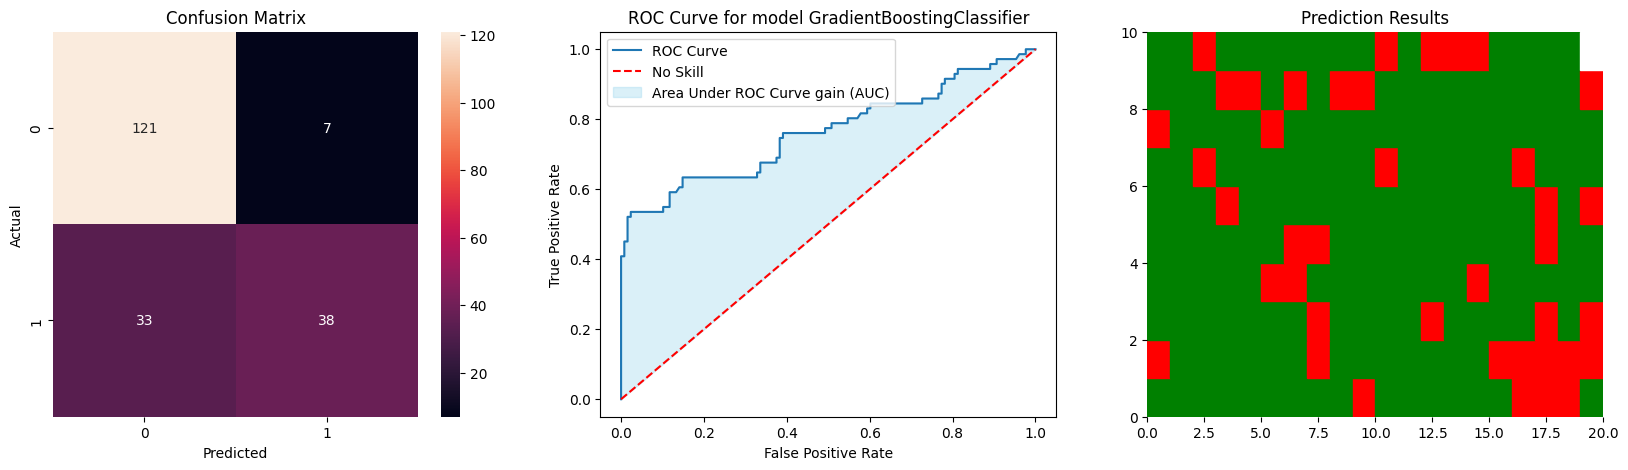

In [38]:
validation_predictions = best_gradientboosting_estimator.predict(validation_data[variable_space])
validation_probabilities = best_gradientboosting_estimator.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'GradientBoostingClassifier')

Interesting! Well, this seems to be our best recall & precision we've had up until now. Lastly, let's look at the RandomForestClassifier:

### RandomForestClassifier

The hyperparameters that we will be tuning to maximize Recall are:
- `N estimators` - The fraction of samples to be used for fitting the individual base learners.
- `Bootstrap` - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. One between True, False.
- `Max Depth` - Maximum depth of the individual regression estimators
- `Min Samples Split` - The minimum number of samples required to split an internal node
- `Min Samples Leaf` - The minimum number of samples required to be at a leaf node
- `Max Leaf Notes` - Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.
- `Criterion` - The function to measure the quality of a split. One between 'gini', 'entropy', 'log_loss'

Both `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes` hyperparameters will be pulled from a randint distribution. 

In [39]:
random_forest_param_distributions = {
    "randomforestclassifier__n_estimators": randint(100, 1000),
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__max_depth": randint(2, 5),
    "randomforestclassifier__min_samples_split" : randint(2, 10),
    "randomforestclassifier__min_samples_leaf" : randint(2, 6),
    "randomforestclassifier__max_leaf_nodes" : randint(2, 9),
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']
}

In [40]:
# %%time
best_randomforest_estimator, cv_results = fn.cross_validation_setup(
                                                models['RandomForestClassifier'],
                                                random_forest_param_distributions,
                                                train_data,
                                                variable_space,
                                                target_variable_column,
                                                10)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Model Hyperparameters: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_leaf_nodes': 5, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__n_estimators': 125}
Best Model Recall Score: 0.4541220307405681


The recall actually was not even that much improved.

The best `bootstrap` metric ended up being `False`.

The best `criterion` ended up being `log_loss`.

The best `max_depth` metric ended up being `2`.

The best `max_leaf_nodes` metric ended up being `4`.

The best `min_samples_leaf` metric ended up being `4`.

The best `min_samples_split` metric ended up being `4`.

The best `n_estimators` metric ended up being `872`.



Let's look at the how these hyperparameters shake up with regards to the model `mean test results` 

In [41]:
cv_results['n_estimators'] = cv_results['n_estimators'].apply(lambda x: randint(100, 1000).rvs())
cv_results['max_depth'] = cv_results['max_depth'].apply(lambda x: randint(2, 5).rvs())
cv_results['min_samples_split'] = cv_results['min_samples_split'].apply(lambda x: randint(2, 10).rvs())
cv_results['min_samples_leaf'] = cv_results['min_samples_leaf'].apply(lambda x: randint(2, 6).rvs())
cv_results['max_leaf_nodes'] = cv_results['max_leaf_nodes'].apply(lambda x: randint(2, 9).rvs())

In [42]:
fig = px.parallel_coordinates(
    cv_results[['n_estimators',
                'max_depth',
                'min_samples_split',
                'min_samples_leaf',
                'max_leaf_nodes',
                'mean_test_score']],
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(title = 'Parallel Coordinates for Random Forest Classifier',
                  title_x=0.5,
                  title_y=0.05,
                  width=1400, height=600)
fig.show()

According to this graph, there are several combinations of hyperparameters that lead to good results on the Random Forest model in terms of recall. This just makes sense as it is very similar to the Gradient Boosting model we have already talked about.

Now let's look at the performance metrics of this best Random Forest model.

Results for RandomForestClassifier model:
Accuracy: 0.7889447236180904
Precision: 0.43661971830985913
Recall: 0.9393939393939394


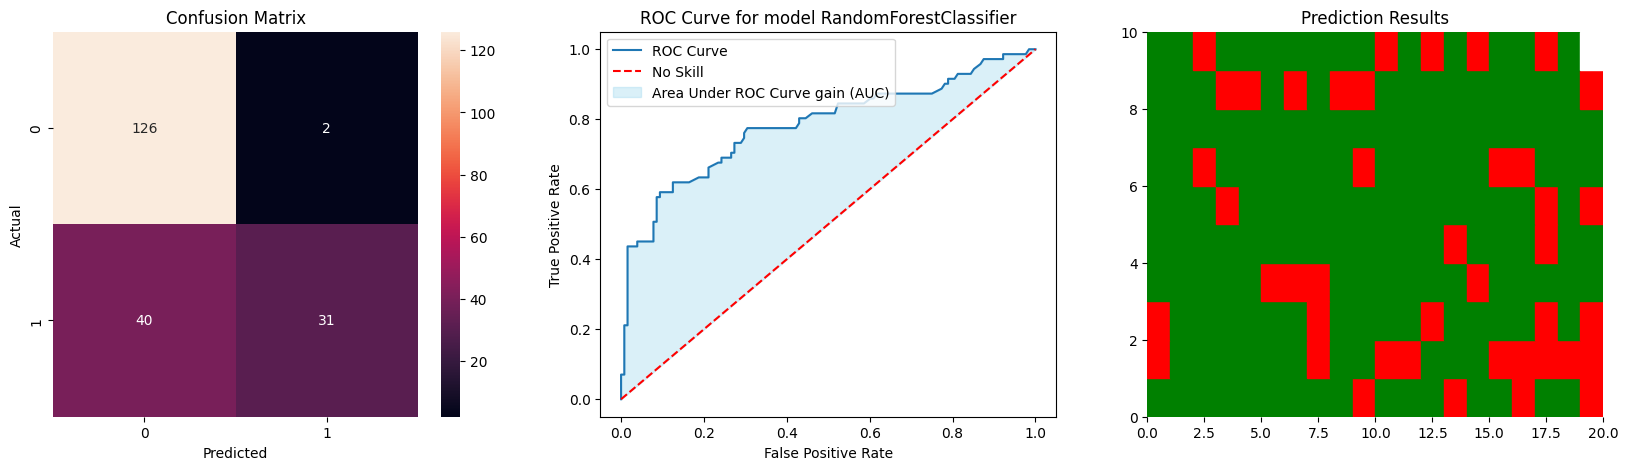

In [43]:
validation_predictions = best_randomforest_estimator.predict(validation_data[variable_space])
validation_probabilities = best_randomforest_estimator.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'RandomForestClassifier')

This seems to be the best model yet in terms of Recall - we have a high of `~0.939`. That is, almost 94% of people that would buy travel insurance, actually get predicted correctly by the Best Gradient Boosted Model. Additionally, the right-most graph seems to be the most green it's been - a visual indication of the amount of right predictions made.

# Trying Out PCA

Now, up until now we have been using all 8 explanatory variables. But that proves to be difficult if you wanted to graph the differences between the points that bought the Travel Insurance and ones that didn't, you would be hard-pressed to find an 8-axis graph. So, why don't we transform the 8 explanatory variables into just 3 using Principal Component Analysis - a method of getting more descriptive/condensed axes from a dataset of multiple different axes. 

In [44]:
pca_model = make_pipeline(preprocessor, PCA(n_components=3))
X = pca_model.fit_transform(train_data[variable_space])
df = pd.DataFrame(data = np.c_[X, train_data['TravelInsurance']], columns=['Feature 1',
                                                                           'Feature 2',
                                                                           'Feature 3',
                                                                           'Label'])
df.head()

,Feature 1,Feature 2,Feature 3,Label
0,-0.224702,0.384154,-0.132589,0.0
1,-0.790501,-1.007348,1.107419,0.0
2,-0.148552,3.019296,0.726429,1.0
3,0.679838,-0.418791,-0.188207,0.0
4,1.346049,-0.197148,-1.186844,1.0


So, the result is that we have 3 features (appropriately named Feature 1, 2, 3). Let's plot it.

In [45]:
points_colorscale = [
                     [0.0, 'rgb(239, 85, 59)'],
                     [1.0, 'rgb(99, 110, 250)'],
                    ]

layout = go.Layout(scene=dict(
                              xaxis=dict(title='Feature 1'),
                              yaxis=dict(title='Feature 2'),
                              zaxis=dict(title='Feature 3')
                             ),
                  showlegend=True
                  )

points = go.Scatter3d(x = df['Feature 1'], 
                      y = df['Feature 2'], 
                      z = df['Feature 3'],
                      mode='markers',
                      text=df['Label'],
                      marker=dict(
                                  size=3,
                                  color=df['Label'],
                                  colorscale=points_colorscale
                            ),
                     )

fig2 = go.Figure(data=[points], layout=layout)
fig2.update_layout(width=800,
                   height=600,
                   title = 'PCA Features by TravelInsurance')
fig2.show()

This is quite fascinating. It seems as though the points actually follow a skewed axis - it's increasing along the Feature 1 - Feature 3 hyperplane. Now, I won't be reshaping it to stand properly - frankly, I don't understand yet how to do so. But if you were to spin the graph so that the points would be coming towards you., you would be able to discern an 'L' shaped decision boundary between the people that bought the Travel Insurance and the ones that did not. 

Let's try and replicate that with the best model we had so far - the `Gradient Boosting Classifier`

Results for GradientBoostingPCAClassifier model:
Accuracy: 0.8241206030150754
Precision: 0.5492957746478874
Recall: 0.9285714285714286


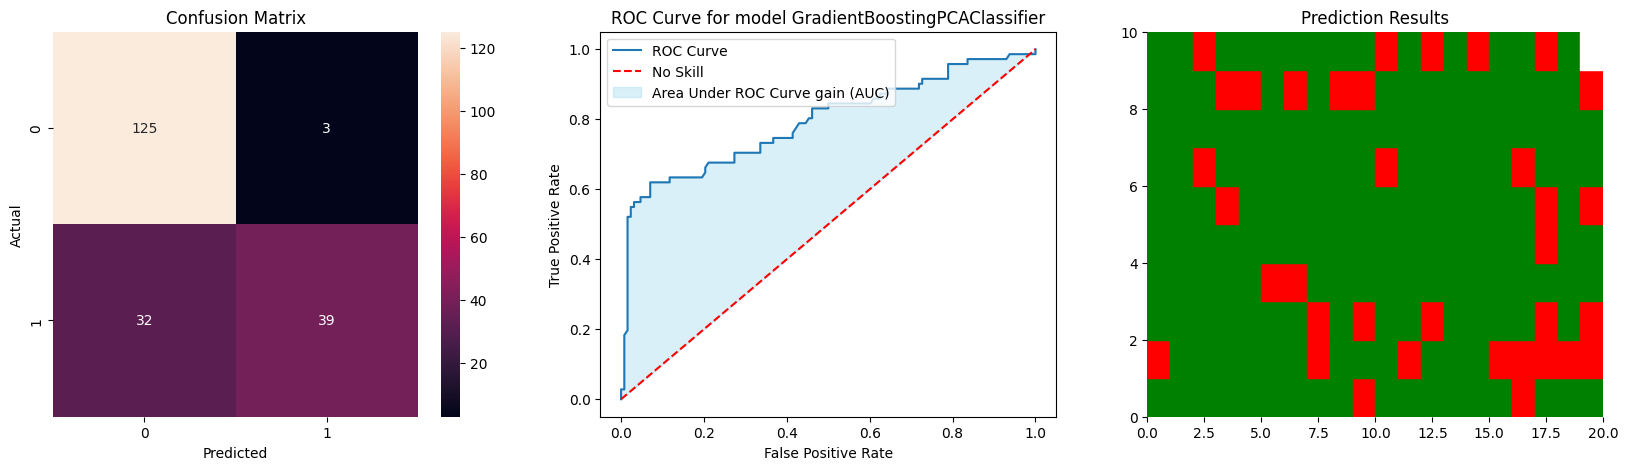

In [46]:
gradient_boosting_PCA_model = make_pipeline(pca_model, GradientBoostingClassifier())

gradient_boosting_PCA_model.fit(train_data[variable_space], train_data[target_variable_column])

validation_predictions = gradient_boosting_PCA_model.predict(validation_data[variable_space])
validation_probabilities = gradient_boosting_PCA_model.predict_proba(validation_data[variable_space])

fn.model_performance_review(validation_predictions, validation_data[target_variable_column],
                            validation_probabilities[:, 1], 'GradientBoostingPCAClassifier')

Phenomenal! The Recall and the Precision seems to be at very high rates. Let's include this model into our final 4 considered models for predicting which customers will buy Travel Insurance and which - won't.

#  Final Testing of Best Models

Finally, we end up in testing our best models - this time with the testing dataset (the one we have kept in a holster this entire time). This step is for us to understand how well did we perform at our jobs.

## Logistic Regression model

Results for LogisticRegressionClassifier model:
Accuracy: 0.8090452261306532
Precision: 0.49295774647887325
Recall: 0.9459459459459459


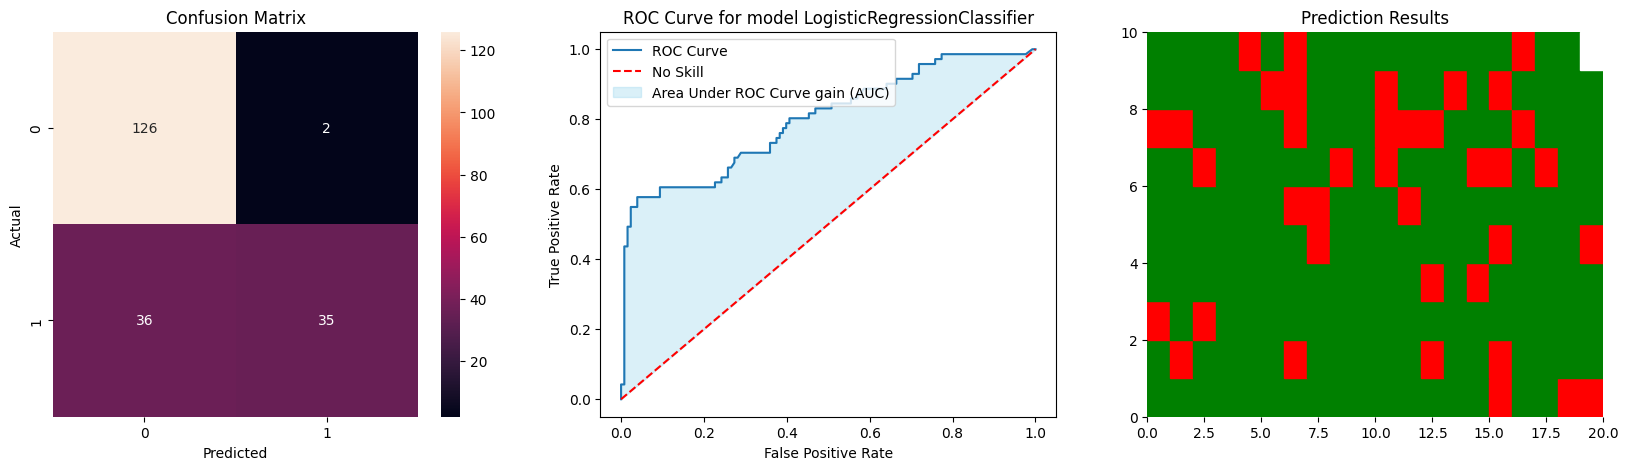

In [47]:
test_predictions = best_logregression_estimator.predict(test_data[variable_space])
test_probabilities = best_logregression_estimator.predict_proba(test_data[variable_space])

fn.model_performance_review(test_predictions, test_data[target_variable_column],
                            test_probabilities[:, 1], 'LogisticRegressionClassifier')

The Logistic Regression Model is actually very accurate (according to our criteria, namely the Recall and Precision). That is actually even evident in the ROC Curve having steeper lines at parts & the prediction results becoming greener and greener. What about the `Random Forest Model`?

## Random Forest model

Results for RandomForestClassifier model:
Accuracy: 0.8040201005025126
Precision: 0.4647887323943662
Recall: 0.9705882352941176


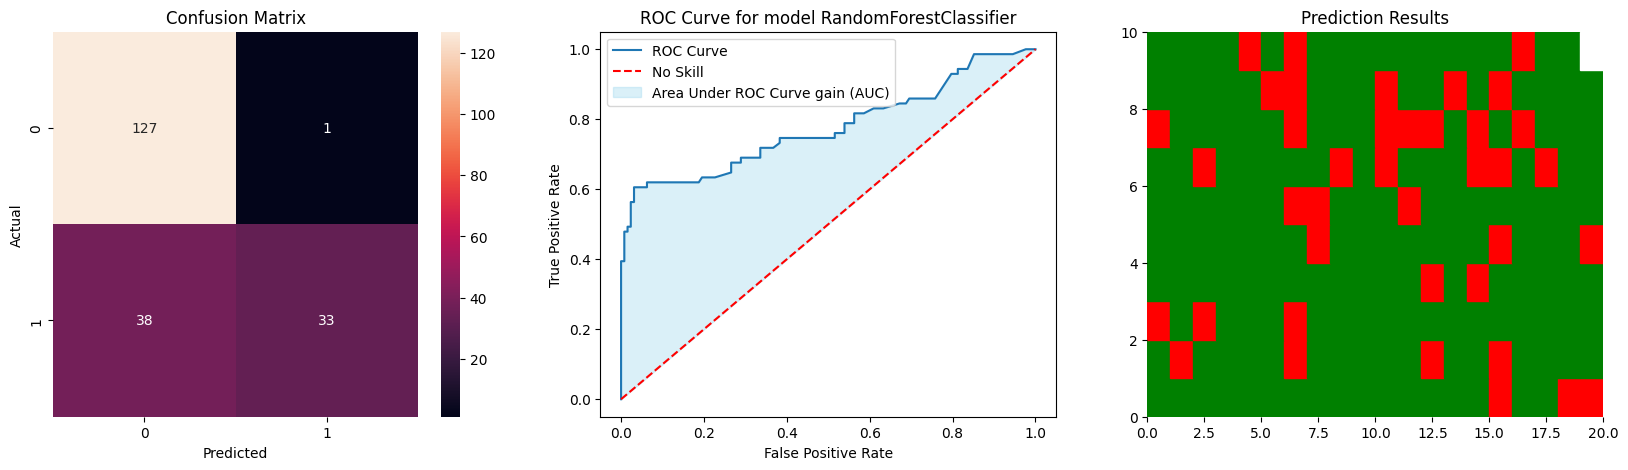

In [48]:
test_predictions = best_randomforest_estimator.predict(test_data[variable_space])
test_probabilities = best_randomforest_estimator.predict_proba(test_data[variable_space])

fn.model_performance_review(test_predictions, test_data[target_variable_column],
                            test_probabilities[:, 1], 'RandomForestClassifier')

The `Random Forest Classifier` is actually even better! With a record Recall of around `~0.97`. The only problem is, is that the precision might have gone down a bit.

## Gradient Boosting model

Results for GradientBoostingClassifier model:
Accuracy: 0.8090452261306532
Precision: 0.5774647887323944
Recall: 0.8367346938775511


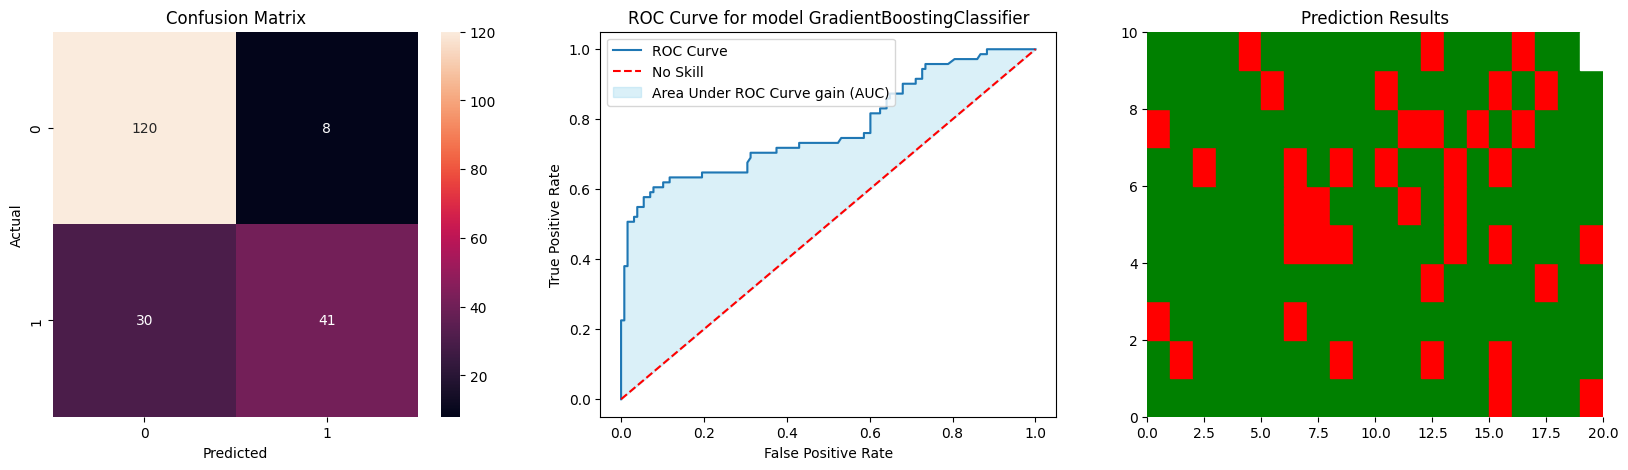

In [49]:
test_predictions = best_gradientboosting_estimator.predict(test_data[variable_space])
test_probabilities = best_gradientboosting_estimator.predict_proba(test_data[variable_space])

fn.model_performance_review(test_predictions, test_data[target_variable_column],
                            test_probabilities[:, 1], 'GradientBoostingClassifier')

The Gradient Boosting Model actually didn't perform as well as the previous models. Perhaps not the best hyperparameter tuning distributions were chosen? Or just the model does not suite the problem really well. Although, the precision of this model is actually the best out of the three we have. How about the PCA version of the Gradient Boosting Classifier? 

## PCA Gradient Boosting model

Results for GradientBoostingPCAClassifier model:
Accuracy: 0.8140703517587939
Precision: 0.5352112676056338
Recall: 0.9047619047619048


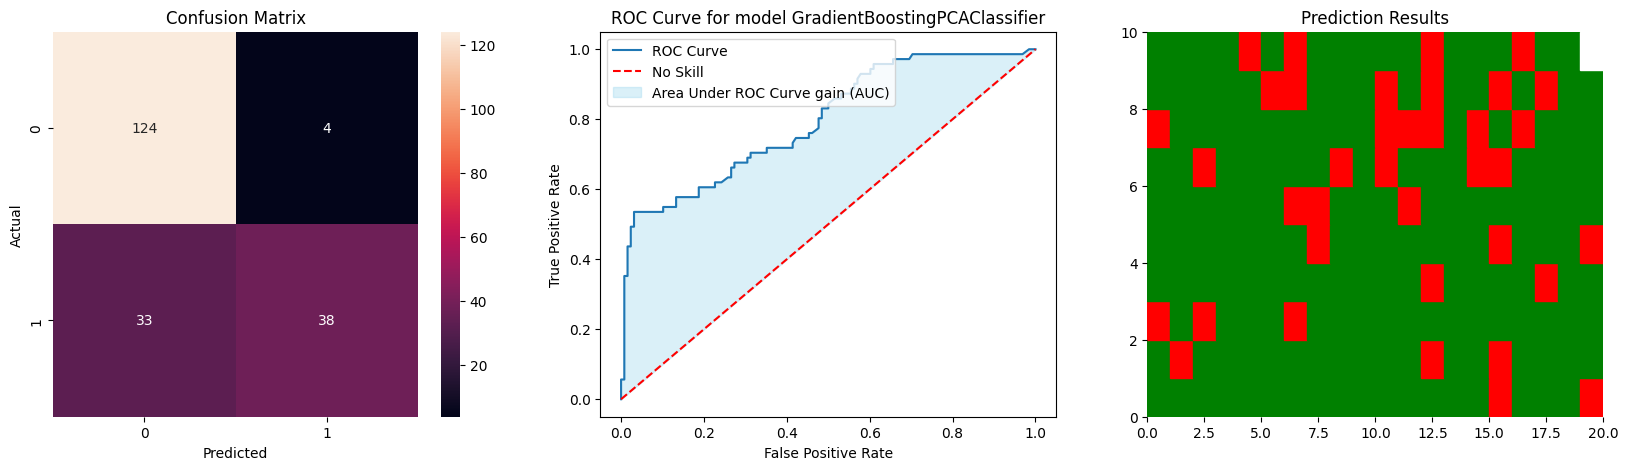

In [50]:
test_predictions = gradient_boosting_PCA_model.predict(test_data[variable_space])
test_probabilities = gradient_boosting_PCA_model.predict_proba(test_data[variable_space])

fn.model_performance_review(test_predictions, test_data[target_variable_column],
                            test_probabilities[:, 1], 'GradientBoostingPCAClassifier')

The PCA version of the Gradient Boosting Classifier did somewhat outperform it's predecessor. However, it did not manage to beat the Decision Tree Classifier in terms of the recall score.

Lastly, if you looked at the Prediction Results separately for each corresponding tested model, you would notice that the read rectangles seem to somewhat overlap, but somewhat - not. Here's where the idea for Model Voting came for this analysis. What if we had these three separate models actually vote together? And have their votes be weighted by their recall score from this previous section?

For this case we use these weights:
1. `Logit Model` - `0.1`
2. `Gradient Boosting Model` - `0.1`
3. `Random Forest Model` - `0.7`
4. `Gradient Boosting PCA Model` - `0.1`

Results for Ensemble Model model:
Accuracy: 0.8090452261306532
Precision: 0.4788732394366197
Recall: 0.9714285714285714


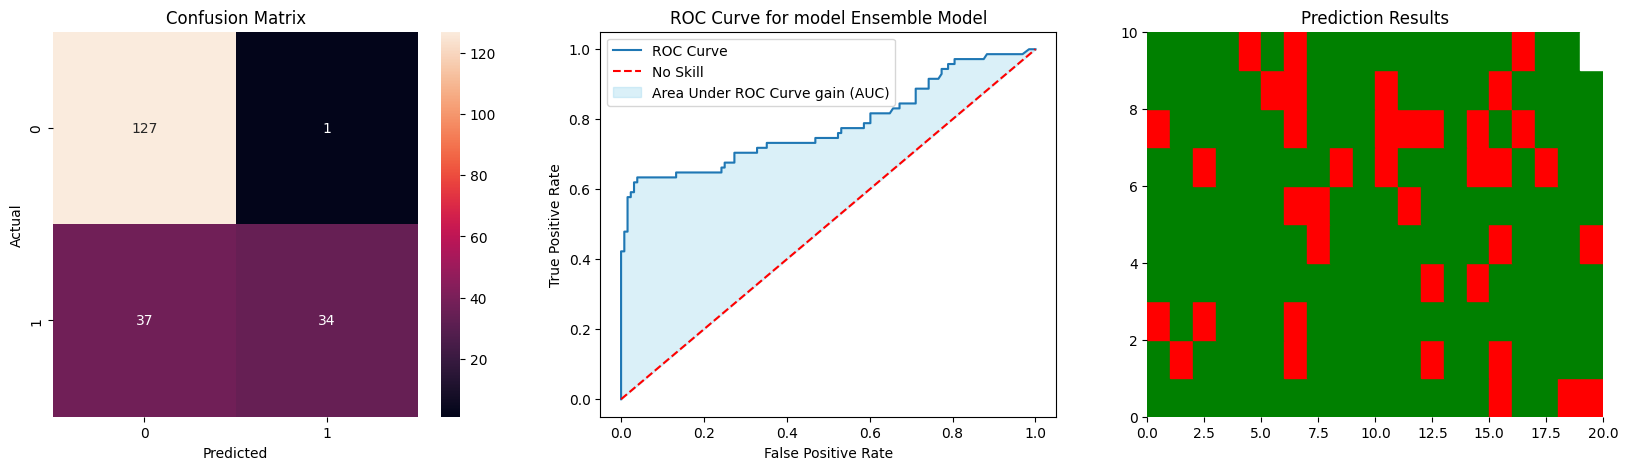

In [51]:
weights = [0.1, 0.1, 0.7, 0.1]

ensemble_model = VotingClassifier(estimators=[('Logit Model',
                                               best_logregression_estimator),
                                              ('GradientBoostedModel',
                                               best_gradientboosting_estimator),
                                              ('RandomForestModel',
                                               best_randomforest_estimator),
                                              ('GradientBoostingPCAClassifier',
                                               gradient_boosting_PCA_model)
                                             ], 
                       voting='soft',
                       weights = weights).fit(train_data[variable_space],
                                              train_data[target_variable_column])


test_predictions = ensemble_model.predict(test_data[variable_space])
test_probabilities = ensemble_model.predict_proba(test_data[variable_space])

fn.model_performance_review(test_predictions, test_data[target_variable_column],
                             test_probabilities[:, 1], 'Ensemble Model')

Finally, we end up with a model that can bring back ~97% of all true travel insurance purchasers. Hope this would help the company.

# Conclusions

Through visual inspection:
1. High-income-earning customers seem to be purchasing travel insurance more than their counterparts.
2. Most of the clients that we have in the dataset have not Ever Travelled Abroad. It could just be because they only fly within their own country. 
3. It seems as though clients with higher amounts of family members & with more AnnualIncome purchase Travel Insurance more.
4. Clients that have Travelled Abroad before seem to be more keen in buying Travel Insurance.
5. Not sick by Chronic Diseases people tend to not take travel insurance.

Model-related:
1. After building most typical models, the best model we are able to build has the accuracy of `0.8040201005025126`, the precision of `0.4647887323943662` & the recall of `0.9705882352941176`. Note that the target of optimization was the `Recall` score.
2. The best model utilises 4 of the best test scoring models voting in a voting classifier.

# Improvements to make

1. Include a section on Statistical inference to answer such questions as "Does the population of clients with larger families buy travel insurance less than clients with small families?", etc.
2. Introduce a dual performance metric (something like the L1_ratio) for choosing the performance of models. This is because there could be arguments about having the model optimize for the precision score instead of recall
3. Be more descriptive with the results and analysis we make.